# Practice Session 03: Find near-duplicates using shingling

In this session we will take a large corpus of tweets and detect near-duplicates on this corpus using a technique known as *shingling*.

Two documents are considered near-duplicates if they share a large amount of ngrams. The *ngrams* of a phrase are overlapping sequences of words of length *n*. For instance, the phrase '*My name is Inigo Montoya. You killed my father. Prepare to die.*' has the following 3-grams:

* 'my name is'
* 'name is inigo'
* 'is inigo montoya'
* ...
* 'my father prepare'
* 'father prepare to'
* 'prepare to die'

To measure the similarity between two sets, we will use the [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index), which is the size of the intersection of the two sets divided by their union. This values goes between 0.0 (meaning the documents have no ngrams in common) to 1.0 (meaning the documents have the same ngrams).

To speed up things, instead of comparing the set of shingles of two documents which can be large, we will derive a fixed-length *signature* or *sketch* for each document. This will be obtained by (1) applying a random permutation to the list of possible ngrams, and (2) pick the ngram that appears first in the permuted list. The Jaccard index between these signatures will be a good approximation of the Jaccard index between the original sets of ngrams. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Judith Camacho Camacho</font>

E-mail: <font color="blue">judith.camacho01@estudiant.upf.edu</font>

Date: <font color="blue">14-10-2020</font>

# 0. Dataset

The corpus you will use is a file named `CovidLockdownCatalonia.json.gz`. This is a gzip-compressed file, which you can de-compress using the `gunzip` command. The file contain about 35,500 messages ("tweets") posted between March 13th, 2020, and March 14th, 2020, containing a hashtag or keyword related to COVID-19, and posted by a user declaring a location in Catalonia.

The tweets are in a format known as [JSON](https://en.wikipedia.org/wiki/JSON#Example). Python's JSON library takes care of translating it into a dictionary.

**How was this file obtained?** This file was obtained from the [CrisisNLP](https://crisisnlp.qcri.org/covid19). This is a website that provides COVID-19 collections of tweets, however, they only provide the identifier of the tweet, known as a tweet-id.

To recover the entire tweet, a process commonly known as *re-hydration* needs to be used, which involves querying an API from Twitter, giving the tweet-id, and obtaining the tweet. This can be done with a little bit of programming or using a software such as [twarc](https://github.com/DocNow/twarc#dehydrate).

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [17]:
# !pip install unidecode

You should consider upgrading via the 'c:\users\judith\anaconda3\python.exe -m pip install --upgrade pip' command.


In [175]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import datetime
import unidecode

In [176]:
# Input file
INPUT_FILENAME = "CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []
MAX_MESSAGES = 10000

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    
    messages_read = 0
    for line in input_file:
            
        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":
            
            messages_read += 1
            
            if messages_read <= MAX_MESSAGES:
                author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 10000 documents


# 1. Auxiliary functions

Implement the Jaccard similarity between two lists: the size of the intersection of two sets, divided by the size of their union.

You can use `set(l)` to convert a list `l` to a set, then `set1.union(set2)` and `set1.intersection(set2)` to compute union and intersection of sets `set1`, `set2`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for function "jaccard_similarity"</font>

In [177]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)  ##set deletes duplicates
    set2 = set(list2)
    if (len(set1.union(set2))==0): return 0
    return len(set1.intersection(set2))/len(set1.union(set2))

Test your function by passing it:

* Two arrays for which the jaccard similarity is 0.0
* Two arrays for which the jaccard similarity is 1/3
* Two arrays for which the jaccard similarity is 1.0
* Two empty arrays should have jaccard similarity 0.0

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code testing "jaccard_similarity"</font>

In [178]:
a1 = [1, 2, 3, 4]
a2 = [5, 6, 7, 8, 9]

print("Test case 1: ", jaccard_similarity(a1,a2))

a1 = [1, 2, 3, 4]
a2 = [1, 2, 3, 8, 9, 5, 6, 7]   #union all numbers not repeated

print("Test case 2: ", jaccard_similarity(a1,a2))


a1 = [1, 2, 3, 4, 5, 6]
a2 = [1, 2, 3, 4, 5, 6]

print("Test case 3: ", jaccard_similarity(a1,a2))

a1 = []
a2 = []

print("Test case 4: ", jaccard_similarity(a1,a2))


Test case 1:  0.0
Test case 2:  0.3333333333333333
Test case 3:  1.0
Test case 4:  0


Implement a function `clean` that cleans-up text by:

* Converting to lowercase
* Removing anything that is not a letter or digit
* [Romanizes](https://en.wikipedia.org/wiki/Romanization) text, replacing "ñ" by "n", "ó" by "o", "à" by "a", "l·l" by "ll", and so on.

You can use `text.lower()` to convert to lowercase, and then `re.sub(...)` to replace parts of the text. See [Python regexps](https://docs.python.org/3/library/re.html).

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code implementing the function "clean"</font>

In [179]:
def clean(text):
    text = text.lower()
    text = re.sub("[^\w\d ]", "", text)
    text = unidecode.unidecode(text)
    return text

    

Test your function by passing it the text "RT @Inigo_1973: I am Iñigo Montoya! https://t.co/aaa". It should return "rt inigo1973 i am inigo montoya httpstcoaaa"

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code testing function "clean"</font>

In [180]:
text = "RT @Inigo_1973: I am Iñigo Montoya! https://t.co/aaa"
print(clean(text))

rt inigo_1973 i am inigo montoya httpstcoaaa


# 2. Implement an n-gram extractor

Implement the function `ngrams(text,size)`, which should produce all sub-sequences of `size` words present in the text. Use the following skeleton:

```python
MIN_TOKEN_LENGTH = 2

def ngrams(text, size):
    tokens = clean(text).split()
    ngrams = []
    # your code here
    return ngrams
```

Note that `ngrams` is a list, and each element of this list is a *string*.

The only words you must consider in a ngram are words having at least `MIN_TOKEN_LENGTH` characters.

You can use the [split](https://docs.python.org/2/library/string.html#string.split) and [join](https://docs.python.org/2/library/string.html#string.join) function of the split library. Remember that to extract elements *i* to *j* of array *a* you use `a[i:j]`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code implementing function "ngrams(text,size)"</font>

In [200]:
MIN_TOKEN_LENGTH = 2
def min_size(x):
    return len(x)>MIN_TOKEN_LENGTH
    

def ngrams(text, size):
    tokens = clean(text).split()
    tokens = list(filter(min_size, tokens))
    grams = []
    grams = [ " ".join(tokens[i:i+size]) for i in range(len(tokens)-(size-1))]
    return grams

Test your function:

```python
print(messages[9780])
print(ngrams(messages[9780], 2))
```

Should print:

```
['diariara comerciants', 'comerciants xinesos', 'xinesos donen', 'donen mascaretes', 'mascaretes gel', 'gel antiseptic', 'antiseptic badalona', 'badalona per', 'per lluitar', 'lluitar contra', 'contra coronavirus', 'coronavirus httpstcoybyxfxphiu']
```

Remember that `ngrams` should return a list of string, not a list of lists, so carefully check that you are returning a list of strings and not a list of lists.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code testing function "ngrams"</font>

In [182]:
print(messages[9780])
print(ngrams(messages[9780], 2))
print(len(messages))

RT @diariARA: Comerciants xinesos donen mascaretes i gel antisèptic a Badalona per lluitar contra el coronavirus https://t.co/ybYXFxphIu
['diariara comerciants', 'comerciants xinesos', 'xinesos donen', 'donen mascaretes', 'mascaretes gel', 'gel antiseptic', 'antiseptic badalona', 'badalona per', 'per lluitar', 'lluitar contra', 'contra coronavirus', 'coronavirus httpstcoybyxfxphiu']
10000


# 3. Estimation for brute force method

The following code, which you should leave as-is, computes the time it takes to compare all first *limit* messages against all first *limit* messages in the array.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [183]:
def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")
        
    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

Use the function above to create a plot in which you have in the x axis the number of messages to check, and in the y axis the time it takes to check that many messages if we use ngrams of size 3. Try with x from *1* to *2001* in increments of *150* (use the [range](https://docs.python.org/3/library/functions.html#func-range) function).

In this plot, remember to include labels in both axes.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for generating the requested plot</font>

In [77]:
time = []
num_mes = []
for lim in range(1, 2001,150):
#     print("for limit= ", limit, "time is: ", time_brute_force_similarities(messages, limit, 3))
    num_mes.append(np.min([len(messages), lim]))
    time.append(time_brute_force_similarities(messages, lim, 3))
    


In [89]:
end = timer()
print(end-start)

2.706589200000053


In [90]:
print(time)
print(num_mes)

[0.00015520000033575343, 1.4561364999999569, 5.661502199999632, 12.4011074, 21.972849900000256, 33.96202540000013, 49.098845900000015, 69.16886770000019, 90.53061029999935, 123.51940869999999, 141.4023115, 170.0061982999996, 208.85755939999945, 238.09491220000018]
[1, 151, 301, 451, 601, 751, 901, 1051, 1201, 1351, 1501, 1651, 1801, 1951]


Text(0, 0.5, 'Time')

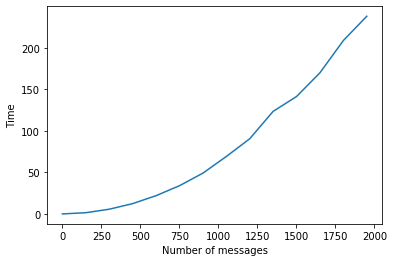

In [81]:
plt.plot(num_mes, time)
plt.xlabel("Number of messages")
plt.ylabel("Time in seconds")

<font size="+1" color="red">Replace this cell with (1) a brief commmentary about what you see in this plot, and (2) your estimate for how long would it take to run the brute force similarity computations for the entire input matrix. Express your estimation in hours, minutes, and seconds, and justify it.</font>

This graph is an exponential. Hence, the brute time to compute the jaccard_similarity grows exponentially with the amount of messages. 
I know that the len(messages) is 10000. I've tried to extarct the formula using the first values, but I am not able to find it. The one that convinces me the most is t= ae^m, but i have also tried with t=am^3 (even though it could be something as t= am^3 + cm^2...)

# 4. Computing the doc-ngram matrix

Now we will compute a matrix in which every row is an ngram, and every column is a document.

This normally done by hashing the ngrams and then every row is an ngram *hash*; in this practice we will skip that step and work directly with one ngram per row, which is conceptually the same and easier to code.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

## 4.1 Create list of all ngrams

Implement code to create the dictionary `ngram_to_index`, which should convert an ngram to an index (a row number) and to create the variable `num_distinct_ngrams` which should contain the number of distinct ngrams.

```python
NGRAM_SIZE = 3

ngram_to_index = {}
next_index = 0


for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        # YOUR CODE HERE
            
num_distinct_ngrams = next_index

print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))
```

Note that the total number of n-grams may vary depending on ho you `clean()` text. In this dataset it should be about 10 times the number of documents.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for creating the ngram_to_index structure.</font>

In [193]:
NGRAM_SIZE = 3

ngram_to_index = {}
next_index = 0


for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        if ngram not in ngram_to_index:
            ngram_to_index[ngram] = next_index
            next_index+=1

num_distinct_ngrams = next_index

print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))

There are 57569 distinct ngrams in the 10000 documents


Test your function by printing the ngram_to_index of the string `"tancat escoles fins"`. The exact index varies,  depending on how you `clean()` text.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for testing the ngram_to_index structure.</font>

In [195]:
print(ngram_to_index["tancat escoles fins"])

739


## 2.2 Create table ngrams x documents

Now we will create a boolean matrix named `M_ngram_doc`, where each row should be an n-gram, and each column should be a document.

There might be documents having less than *NGRAM_SIZE* words and thus containing no shingles. You can skip those documents above (when reading the file), or handle them here.

The next code creates an empty matrix. Leave as-is. If you run out of memory, limit the number of documents you read at the beginning of this file, for instance, read only the first 10,000 or the first 7,000 documents, and then try again.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [194]:
# Create matrix filled with boolean False
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print number of rows and columns
print("Rows: %d (distinct shingles)" % len(M_ngram_doc))
print("Columns: %d (distinct documents)" % len(M_ngram_doc[0]))

Rows: 57569 (distinct shingles)
Columns: 10000 (distinct documents)


Complete the matrix `M_ngram_doc` so that position i, j (row, column) holds a `True` if document j contains ngram i, otherwise holds `False`. You can use the following skeleton:

```python
for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, ngram_size)
    for ngram in all_ngrams:
        # replace this comment with your code
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for filling the M_ngram_doc matrix.</font>

In [198]:
for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        index = ngram_to_index[ngram]
        M_ngram_doc[index,docid] = True


Print a couple of documents (columns). All columns should be very sparse, i.e., mostly zeroes. Print the following for messages number 28 and 3689:

```
Positions of non-zeros in column of docid 28 of M_ngram_doc
Clean message : rt 324cat el bce decep els inversors en plena crisi del coronavirus i libex sensorra un 14 el record duna sessio httpstcotqsf
Non-zeros     : [347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359]
```

Note that the specific ngram ids you will get depend on your cleanup process.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [199]:
print(clean(messages[28]))
non_zeros = np.array(np.where(M_ngram_doc[:, 28] == True))
print(non_zeros)
# ngrams = ngrams
# print(np.array(all_ngrams)[ngrams])


print(clean(messages[3689]))
non_zeros = np.array(np.where(M_ngram_doc[:, 3689] == True))
print(non_zeros)

rt 324cat el bce decep els inversors en plena crisi del coronavirus i libex sensorra un 14 el record duna sessio httpstcotqsf
[[347 348 349 350 351 352 353 354 355 356 357 358 359]]
rt elpuntavui coronavirus tancat lespai aeri de la conca dodena es prohibeixen els vols daeronaus i es restringeixen els daparells
[[25828 25829 25830 25831 25832 25833 25834 25835 25836 25837 25838 25839]]


<font size="+1" color="red">Replace this cell with your code for printing rows 28 and 3689 of the M_ngram_doc matrix.</font>

In [201]:
print(M_ngram_doc[28, :])
print(M_ngram_doc[3689, :])

[False False  True ... False False False]
[False False False ... False False False]


# 3. Implement a permutation generator

Implement the function `random_permutation(k)`, which should generate a random permutation of the array `[0, 2, 3, ..., k-1]`. Tip: the function `random.shuffle(...)` might be useful, and if you want to use `range(...)`, which returns an iterator, you will need to convert it to a list using `list(range(...))`.

Remember to test your code. For instance, a permutation of 20 elements should look like this:

```
[14, 10, 0, 8, 4, 12, 5, 19, 6, 9, 15, 13, 16, 2, 17, 11, 7, 3, 18, 1]
```

Every number appears only once, and all numbers from 0 to 19 appear in the permutation.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for "random_permutation"</font>

In [213]:
def random_permutation(k):
    x= np.random.permutation(k)
    return x
    

In [212]:

random_permutation(20)

array([ 2,  1,  0,  9,  3, 10, 16, 19,  8,  5, 13, 17,  4, 14,  6, 12, 15,
       11, 18,  7])

Further test this by applying the same permutation on two lists. The code below, which you must leave as-is,  should print both lists in the same ordering, so that *alpha* is in the same position of *a*, *beta* in the same position as *b*, and so on.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [210]:
# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["a", "b", "c", "d", "e"]
original_list_2 = ["alpha", "beta", "gamma", "delta", "epsilon"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['e', 'c', 'a', 'b', 'd']
['epsilon', 'gamma', 'alpha', 'beta', 'delta']

Test another permutation
['d', 'c', 'e', 'b', 'a']
['delta', 'gamma', 'epsilon', 'beta', 'alpha']


# 4. Compute the signature of each document

Now comes the core of the algorith. We will create a new matrix `M_signature_doc` having a small number of rows (the *signature size*), which will be equivalent to the number of permutations we use. The number of columns will continue being the number of documents.

First, we create the permutations and store them in an array of arrays named `permutations`, with the following code, which you should leave as-is.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [216]:
NUM_PERMUTATIONS = 4

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))
    
# Visualize the permutations by printing their first 3 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, ..." % (i, permutation[0], permutation[1], permutation[2] ))

Permutation 0: 17810, 24639, 33362, ...
Permutation 1: 34923, 30855, 9690, ...
Permutation 2: 21653, 31883, 4607, ...
Permutation 3: 21751, 40837, 38125, ...


Now, you implement the signature construction. The matrix `M_signature_doc` should contain in row *i*, column *j*, the first ngram (the "minimum" one) that is present in a column (document), according to the order given by a permutation.

This process may take a few minutes to be completed. You can use the following template:

```python
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        # replace this comment with your code
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for creating M_signature_doc</font>

In [217]:
# voy sacando bolas de bingo (valor de la permutacion en x pos que tmbien es el ngram en si) con una misma persona que solo tiene un numero(documento) hasta que aciertas el numero. Esto se repite para las 10000
# esto se repite num_perms partidas
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):  ##recorre las 57000 hasta qeu encuentra el primero segun la permutacion
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        M_signature_doc[permutation_num, docid] = find_first_one(docid, permutation)

Creating signatures for permutation 1/4
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 2/4
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 3/4
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Sca

Test your code by checking the signatures of two documents that are near-duplicates,using the next code, which you should leave as-is. Being near-duplicates, we expect these should have many ngrams in common, and hence, with high probability they will have many elements in common in their signatures.

Note that your ngrams and signatures vectors might be different than what we show here, given the differences in cleaning procedures and the randomness of the permutations.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [219]:
def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, i] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    print("Signature     : %s" % extract_signature(i))

        
i = 84
j = 6586

print_sig(messages, M_ngram_doc, M_signature_doc, i )

print()

print_sig(messages, M_ngram_doc, M_signature_doc, j )

Document #84
Message       : RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma…
Clean message : rt emergenciescat  es demana a la ciutadania limitar al maxim i si es pot evitar desplacaments de cap de setmana tot el que sigui ma
Ngrams        : [200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210]
Signature     : [206.0, 210.0, 201.0, 205.0]

Document #6586
Message       : RT @emergenciescat: ⚠️ El @govern demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS innecessaris. Tot el que sigui…
Clean message : rt emergenciescat  el govern demana a la ciutadania limitar al maxim i si es pot evitar desplacaments innecessaris tot el que sigui
Ngrams        : [200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210]
Signature     : [3317.0, 210.0, 201.0, 205.0]


In [220]:
print(list(ngram_to_index.items())[3317])

('evitar desplacaments innecessaris', 3317)


# 5. Compare all pairs of signatures

Now we are ready to compare all documents by their signatures, instead of by their content. Write code to compare all pairs of documents. Use the following template:

```python
is_possible_duplicate = {}

# Iterate through all documents
for docid1 in range(len(messages)):

    # Counters for partial and complete signature matches
    count_sig_matches_partial = 0
    count_sig_matches_complete = 0

    # Extract the signature of the doc1
    signature1 = extract_signature(docid1)
    if docid1 % 500 == 0:
        print("%d/%d documents scanned" % (docid1, len(messages)))
    
    # Iterate through documents with docid larger than doc1
    for docid2 in range(docid1+1, len(messages)):
        
        # If this has not already been marked as duplicate of another document
        if docid2 not in is_possible_duplicate:
            
            # Extract signature of doc2
            signature2 = extract_signature(docid2)
            
            # REPLACE THIS COMMENT WITH YOUR CODE:
            # - Increase count_sig_matches* as needed
            # - Include docid2 in is_possible_duplicate if needed
            
    # REPLACE THIS COMMENT WITH YOUR CODE
    # - If the number of partial and complete matches exceeds a threshold
    #   print the document doc1 and indicate how many matches it has
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for comparing all signatures</font>

In [225]:
# para cada doc cogemos 4 ngrams random presentes en el. Hemos usado su shingle_id para generar una firma del doc. usamos las mismas permutaciones para todos los documetnos 
# ergo, como usamos el shingle_id, es posible que salga la misma signature en distintos docs
is_possible_duplicate = {}
threshold_partial = 20
threshold_complete = 5

# Iterate through all documents
for docid1 in range(len(messages)):

    # Counters for partial and complete signature matches
    count_sig_matches_partial = 0
    count_sig_matches_complete = 0

    # Extract the signature of the doc1
    signature1 = extract_signature(docid1)
    if docid1 % 500 == 0:
        print("%d/%d documents scanned" % (docid1, len(messages)))

    # Iterate through documents with docid larger than doc1
    for docid2 in range(docid1+1, len(messages)):

        # If this has not already been marked as duplicate of another document
        if docid2 not in is_possible_duplicate:

            # Extract signature of doc2
            signature2 = extract_signature(docid2)

            similarity = jaccard_similarity(signature1, signature2)
            if (similarity > 0):
                if (similarity == 1):
                    count_sig_matches_complete += 1
                    is_possible_duplicate[docid2] = docid1
                else:
                    count_sig_matches_partial += 1
    
            

    # REPLACE THIS COMMENT WITH YOUR CODE
    # - If the number of partial and complete matches exceeds a threshold
    #   print the document doc1 and indicate how many matches it has
    if (count_sig_matches_partial>=threshold_partial or count_sig_matches_complete>=threshold_complete):
        print("\nNum of doc: ", docid)
        print("Document: ", messages[docid1])
        print("Partial matches: ", count_sig_matches_partial)
        print("Complete matches: ", count_sig_matches_complete)


0/10000 documents scanned

Num of doc:  9999
Document:  RT @XSalaimartin: Fa temps que sabem que aquest tal Garcia-Page és un miserable. Però amb això se supera fins i tot a sí mateix. https://t.…
Partial matches:  25
Complete matches:  1

Num of doc:  9999
Document:  RT @elsquissos: Ens en sortirem! #COVID19. Però tenim un dubte! 🤔
En cas de confinament, podríeu informar-nos dels permisos o del què cal f…
Partial matches:  0
Complete matches:  7

Num of doc:  9999
Document:  RT @vpartal: Les dades: Espanya ja supera Itàlia en la velocitat dels contagis de la Covid-19 https://t.co/724RQiZW79
Partial matches:  18
Complete matches:  14

Num of doc:  9999
Document:  RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma…
Partial matches:  20
Complete matches:  71

Num of doc:  9999
Document:  RT @Ferran_Bel: Els 2.800 milions € que ahir va anunciar el President del Gobierno per la Sanitat de les CCAA per 

<font size="+1" color="red">Replace this cell with a brief commentary, based on the results above, about one tweet that has a substantial number of complete matches, but few partial matches. Include the full text of the original tweet. Comment on why you believe this tweet is not being changed much when copied or re-tweeted.</font>

This tweet:
RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma…
has 71 complete matches and 20 partial. The reason for this phenomena is because it's a retweet from an Official account of the government, hence people is not changing it because it's official information so they just want to share it with others.

<font size="+1" color="red">Replace this cell with a brief commentary, based on the results above, about one tweet that has a substantial number of partial matches, but fewer complete matches. Include the full text of the original tweet and one near duplicate (that cannot be identical to the original tweet).</font>

This tweet:  RT @emergenciescat: ✅ Què puc fer i ⛔ què no si estic en una zona afectada pel confinament? 

#ProteccioCivil #Coronavirus https://t.co/lxz…
It has 210 partial matches and 6 complete. This is because this tweet is retweet many times but with people giving opinions on the recommendations it contain, because as we all know, many of these, don't make any sense, for instance.


# DELIVER (individually)

Remember to read the section on "delivering your code" in the [course evaluation guidelines](https://github.com/chatox/data-mining-course/blob/master/upf/upf-evaluation.md).

Deliver a zip file containing:

* This notebook

## Extra points available

For more learning and extra points, do a fair comparison of running time between a method that compares all ngrams and a method that compares all signatures, for 3 different signature sizes. Include a plot of running time versus number of documents to be compared, for the two methods and the three signature sizes, that is six lines in your plot (remember to include a legend).

**Note:** if you go for the extra points, add ``<font size="+2" color="blue">Additional results: running time comparison</font>`` at the top of your notebook.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>